# Refining the spin direction

This notebook provides examples of two methods for refining the spin direction: 
   1. Updating the basis vector(s) and calling the makeSpins() function, which is a very general method and will work for magnetic structures of arbitrary complexity;
   2. Storing the locations of the "up" spins and "down" spins and updating them without calling makeSpins(), which is faster and well suited for simple collinear magnetic structures.

In [2]:
### Import the necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from diffpy.mpdf import *
from diffpy.Structure import loadStructure
from scipy.optimize import least_squares

### Set all plots to be inline
%matplotlib notebook

In [5]:
### Make the magnetic structure
PDFguiFile = 'MnOpdfgui.ddp'
struc = getStrucFromPDFgui(PDFguiFile,0)

th0, phi0 = np.arccos(np.random.uniform(-1,1)),np.random.uniform(-np.pi,np.pi)
svec = np.array([np.sin(th0)*np.cos(phi0),np.sin(th0)*np.sin(phi0),np.cos(th0)])
msp = MagSpecies(struc,magIdxs=[0,1,2,3],ffparamkey='Mn2',rmaxAtoms=50,basisvecs=svec,
                kvecs=np.array([0.5,0.5,0.5]),label=str(0))

mstr=MagStructure()
mstr.loadSpecies(msp)
mstr.makeAll()


### Get the data and make the calculator
r,d = getDiffData(PDFguiFile)

mc = MPDFcalculator(mstr)
mc.rmin = r.min()
mc.rmax = r.max()

### Define a residual function that allows moment directions to vary

<IPython.core.display.Javascript object>


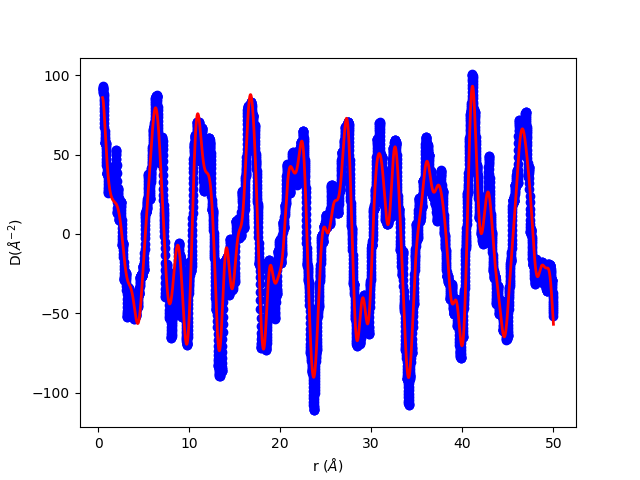

In [6]:
def residual(p,ydata):
    oscale,pscale,damp,th,phi = p
    newsvec = np.array([np.sin(th)*np.cos(phi),np.sin(th)*np.sin(phi),np.cos(th)])
    mstr.species['0'].basisvecs = newsvec
    mstr.makeSpins()
    mc.ordScale = oscale
    mc.paraScale = pscale
    mc.dampRate = damp
    return ydata - mc.calc(both=True)[2]

p0 = [0.1,0.1,0.1,np.arccos(np.random.uniform(-1,1)),np.random.uniform(-np.pi,np.pi)]
optimized = least_squares(residual,p0,bounds=[[0,0,0,0,-np.pi],[10,10,10,np.pi,np.pi]],
                          args=(d,))
fit = mc.calc(both=True)[2]

fig=plt.figure()
ax=fig.add_subplot(111)
ax.plot(r,d,'bo',linestyle='none')
ax.plot(r,fit,'r-',lw=2)
ax.set_xlabel('r ($\AA$)')
ax.set_ylabel('D($\AA^{-2}$)')

plt.show()    

### Visualize the refined magnetic structure

<IPython.core.display.Javascript object>


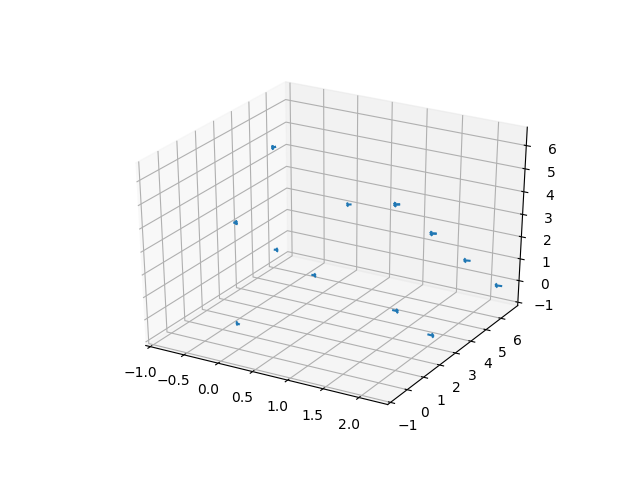

[-0.26131746  0.79943488 -0.5409409 ] -0.0028234704948


In [7]:
### Visualize the magnetic structure
uc = struc[:4].xyz
visatoms = uc.copy()
visatoms = np.concatenate((visatoms,visatoms+np.array([0,0,1]),visatoms+np.array([0,1,0]),visatoms+np.array([0,0,1])))
visatoms = struc.lattice.cartesian(visatoms)
visspins = mstr.spinsFromAtoms(visatoms,fractional=False)
mstr.visualize(visatoms,visspins)

print mstr.spins[0], (mstr.spins[0]).sum()

The refined spin direction is nearly perfectly perpendicular to the (111) direction, as expected.

### Faster method: Use masking to avoid having to regenerate spins each iteration

In [9]:
### Make the magnetic structure
PDFguiFile = 'MnOpdfgui.ddp'
struc = getStrucFromPDFgui(PDFguiFile,0)

th0, phi0 = np.arccos(np.random.uniform(-1,1)),np.random.uniform(-np.pi,np.pi)
svec = np.array([np.sin(th0)*np.cos(phi0),np.sin(th0)*np.sin(phi0),np.cos(th0)])
msp = MagSpecies(struc,magIdxs=[0,1,2,3],ffparamkey='Mn2',rmaxAtoms=50,basisvecs=svec,
                kvecs=np.array([0.5,0.5,0.5]),label=str(0))

mstr=MagStructure()
mstr.loadSpecies(msp)
mstr.makeAll()


### Get the data and make the calculator
r,d = getDiffData(PDFguiFile)

mc = MPDFcalculator(mstr)
mc.rmin = r.min()
mc.rmax = r.max()

In [11]:
### Make the masks
upMask = (np.apply_along_axis(np.linalg.norm,1,mstr.spins-svec)<0.1)
downMask = ~upMask
print mstr.spins[upMask][:4]
print mstr.spins[downMask][:4]

[[ 0.04310885 -0.98299727  0.17848806]
 [ 0.04310885 -0.98299727  0.17848806]
 [ 0.04310885 -0.98299727  0.17848806]
 [ 0.04310885 -0.98299727  0.17848806]]
[[-0.04310885  0.98299727 -0.17848806]
 [-0.04310885  0.98299727 -0.17848806]
 [-0.04310885  0.98299727 -0.17848806]
 [-0.04310885  0.98299727 -0.17848806]]


#Long#:I didn't quite understand how masking is used. Is it possible to write some more words about it?

<IPython.core.display.Javascript object>


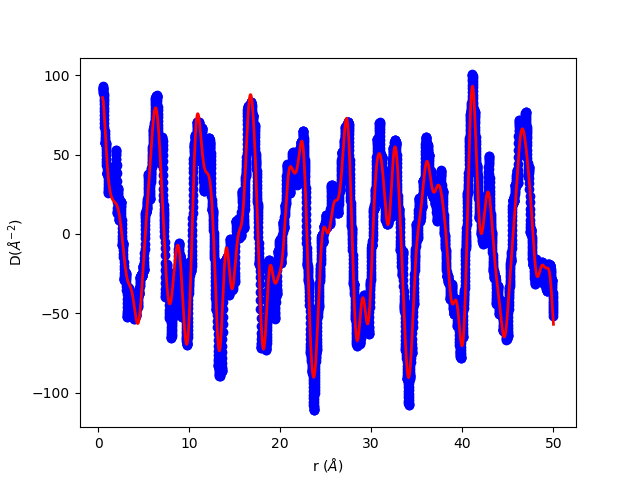

[-0.26746538  0.80072514 -0.53600514] -0.0027453782633


In [12]:
def residual(p,ydata):
    oscale,pscale,damp,th,phi = p
    newsvec = np.array([np.sin(th)*np.cos(phi),np.sin(th)*np.sin(phi),np.cos(th)])
    mstr.spins[upMask]=newsvec
    mstr.spins[downMask]=-newsvec
    mc.ordScale = oscale
    mc.paraScale = pscale
    mc.dampRate = damp
    return ydata - mc.calc(both=True)[2]

p0 = [0.1,0.1,0.1,np.arccos(np.random.uniform(-1,1)),np.random.uniform(-np.pi,np.pi)]
optimized = least_squares(residual,p0,bounds=[[0,0,0,0,-np.pi],[10,10,10,np.pi,np.pi]],
                          args=(d,))
fit = mc.calc(both=True)[2]

fig=plt.figure()
ax=fig.add_subplot(111)
ax.plot(r,d,'bo',linestyle='none')
ax.plot(r,fit,'r-',lw=2)
ax.set_xlabel('r ($\AA$)')
ax.set_ylabel('D($\AA^{-2}$)')

plt.show()    

print mstr.spins[0],(mstr.spins[0]).sum()

In [ ]:
plt.close('all')